# Imports

In [11]:
from pyspark.sql import DataFrame, functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, BooleanType, LongType, DoubleType, ArrayType, DateType, MapType
from pyspark.ml.feature import Bucketizer
from matplotlib import pyplot as plt
import seaborn as sns
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, MinHashLSH, MinHashLSHModel, CountVectorizer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.stat import Summarizer
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
from pyspark.sql import Window
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALSModel

# Create Spark session

In [6]:
from dtu_ctfds_02807_proj.context_creation import create_context

local = True
sc, spark = create_context(local)

Already been executed once, not running again!


# Load data

In [ ]:
if local:
    # Use sample with users that have left many reviews
    game_reviews = spark.read.parquet('data/many_reviews_users_parquet')
    games = spark.read.parquet('data/steam_games_parquet')
else:
    game_reviews = spark.read.parquet("file:////work/ds/steam_reviews_parquet")
    games = spark.read.parquet('file:////work/ds/steam_games_parquet')
    

# game_reviews: DataFrame = game_reviews.persist()
# games: DataFrame = games.persist()

# ALS Model

In [ ]:
game_ratings = game_reviews\
    .filter(F.col("author_steamid").isNotNull())\
    .withColumn(
        'rating',
        F.when(game_reviews.recommended == True, 1).otherwise(-1)
    )

user_indexer = StringIndexer(inputCol="author_steamid", outputCol="user_index")

game_ratings = user_indexer.fit(game_ratings).transform(game_ratings)

window_spec = Window\
    .partitionBy("author_steamid")\
    .orderBy(F.rand())

df_with_row_number = game_ratings\
    .withColumn('row_number', F.row_number().over(window_spec))

reviews_test = df_with_row_number\
    .filter(F.col('row_number') == 1)\
    .drop('row_number')\
    .cache()

reviews_train = df_with_row_number\
    .filter(F.col('row_number') > 1)\
    .drop('row_number')\
    .cache()

In [9]:

explicit_als = ALS(
    maxIter=50,
    rank=20,
    regParam=0.01,
    userCol="user_index",
    itemCol="app_id",
    ratingCol="rating",
    coldStartStrategy="drop"
)

In [10]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

reviews_train = reviews_train.na.drop(subset=["user_index", "app_id", "rating"])

# Simple model for debugging
explicit_als = ALS(
    userCol="user_index",
    itemCol="app_id",
    ratingCol="rating",
    coldStartStrategy="drop"
)

# Simple example for debugging
param_grid = ParamGridBuilder() \
    .addGrid(explicit_als.maxIter, [20]) \
    .addGrid(explicit_als.rank, [20]) \
    .addGrid(explicit_als.regParam, [0.01]) \
    .build()

rmse_evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

# Define CrossValidator
cv = CrossValidator(
    estimator=explicit_als,
    estimatorParamMaps=param_grid,
    evaluator=rmse_evaluator,
    numFolds=3,
)

# Fit the model
model = cv.fit(reviews_train)

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


In [ ]:

implicit_als = ALS(
    maxIter=50,
    rank=20,
    regParam=0.01,
    userCol="user_index",
    itemCol="app_id",
    ratingCol="author_playtime_forever",
    coldStartStrategy="drop",
    implicitPrefs=True
)

In [12]:
# Extract the best model
explicit_model: ALSModel = model.bestModel

# Print parameters of the best model
print('Rank:', explicit_model.rank)
print('MaxIter:', explicit_model._java_obj.parent().getMaxIter())
print('RegParam:', explicit_model._java_obj.parent().getRegParam())

Rank: 20
MaxIter: 20
RegParam: 0.01


In [13]:
explicit_predictions = explicit_model.transform(reviews_test).cache()

In [ ]:
implicit_model = implicit_als.fit(reviews_train)

implicit_predictions = implicit_model.transform(reviews_test).cache()

implicit_predictions\
    .show(5)

In [15]:
# Round predictions to -1 or 1
rounded_explicit_predictions = explicit_predictions\
    .withColumn(
        'prediction',
        F.when(F.col('prediction') > 0, 1.).otherwise(-1.)
    )

In [16]:
reviews_by_user = reviews_train\
    .groupBy("author_steamid")\
    .agg(
        F.count('review_id').alias('review_count'),
    )

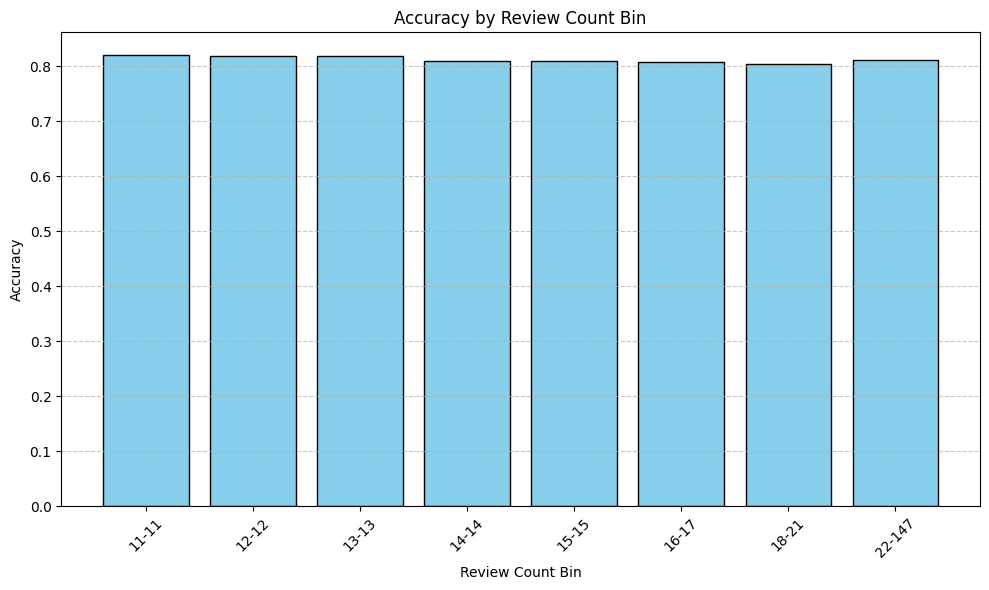

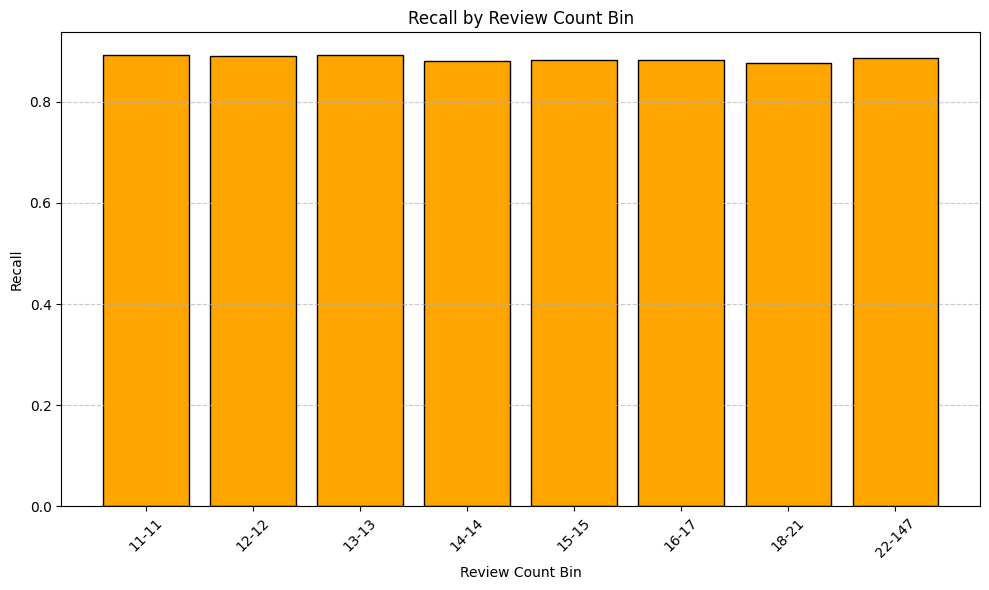

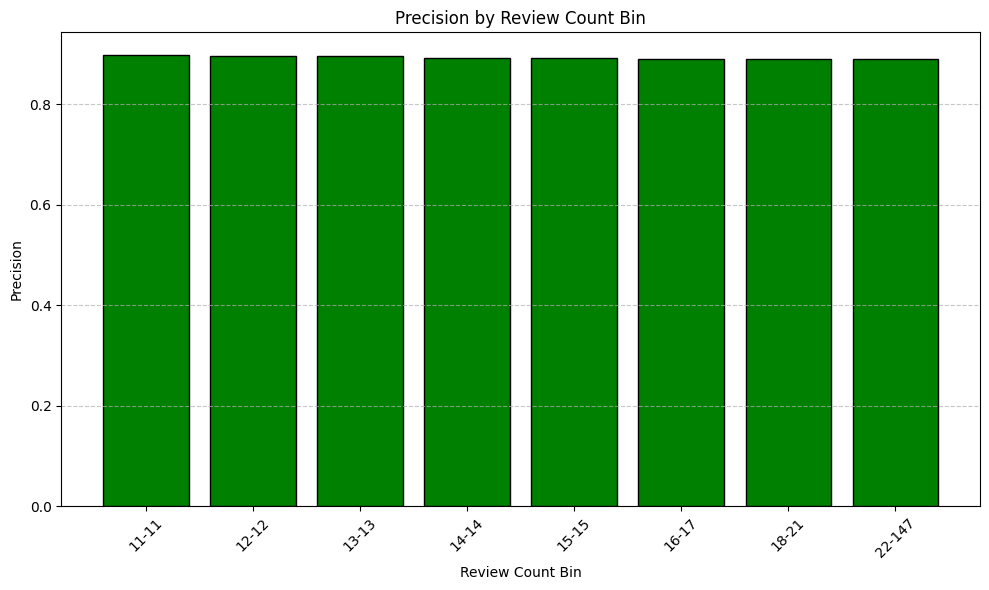

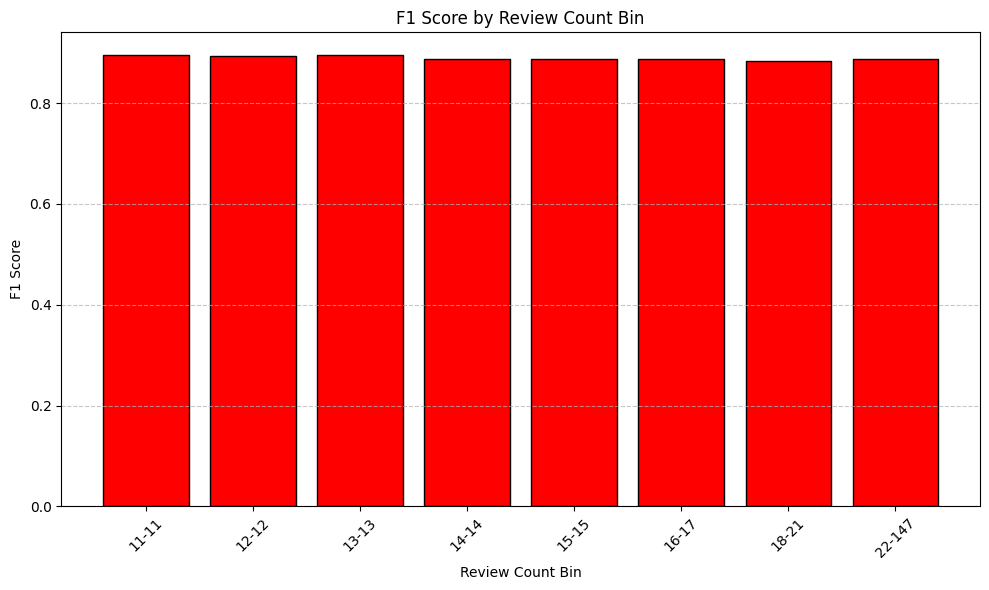

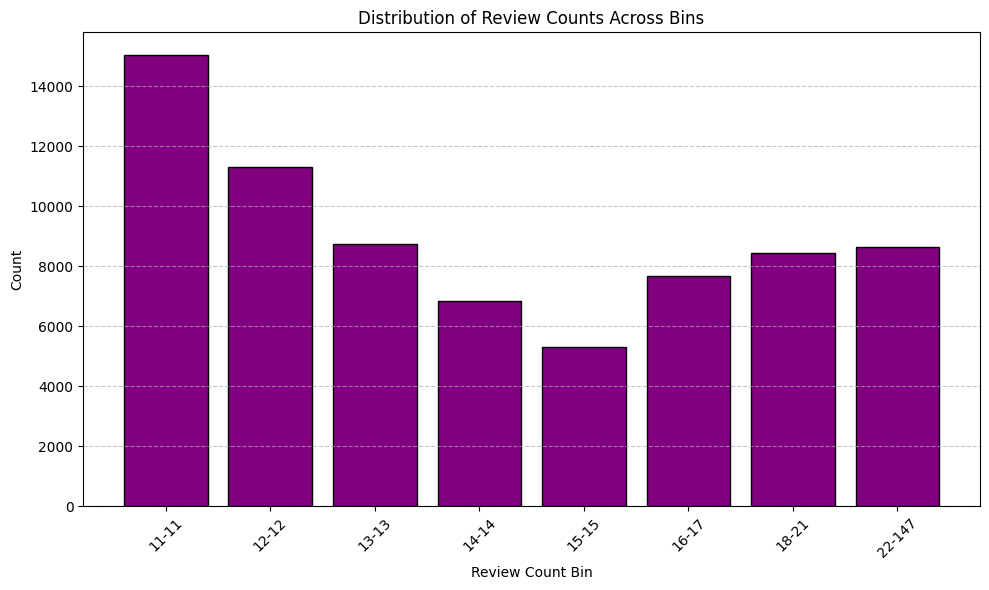

In [17]:
rounded_pred_review_count = rounded_explicit_predictions.drop("review_count")\
    .join(reviews_by_user, on="author_steamid", how="inner").cache()

# Generate n same-sized buckets for review counts
n_buckets = 10
splits = rounded_pred_review_count\
    .select("review_count")\
    .approxQuantile("review_count", [i / n_buckets for i in range(n_buckets + 1)], 0.01)

splits = np.unique(splits)

# Step 2: Generate dynamic bin labels
bin_labels = [
    f"{int(splits[i])}-{int(splits[i+1]) - 1}" if splits[i+1] != float('inf') else f"{int(splits[i])}+"
    for i in range(len(splits) - 1)
]

# Step 3: Apply Bucketizer
bucketizer = Bucketizer(
    splits=splits,
    inputCol="review_count",
    outputCol="review_count_bin"
)

binned_df = bucketizer.transform(rounded_pred_review_count)

# Map bin indices to dynamic labels
def map_bins(bin_index):
    return bin_labels[int(bin_index)] if int(bin_index) < len(bin_labels) else "Unknown"

map_bins_udf = F.udf(map_bins, StringType())

binned_df = binned_df.withColumn(
    "review_count_bin_label",
    map_bins_udf(F.col("review_count_bin"))
)

# Step 4: Aggregate metrics by bin
metrics_df = binned_df.groupBy("review_count_bin", "review_count_bin_label").agg(
    F.count(F.when((F.col("prediction") == 1) & (F.col("rating") == 1), 1)).alias("TP"),
    F.count(F.when((F.col("prediction") == 1) & (F.col("rating") == -1), 1)).alias("FP"),
    F.count(F.when((F.col("prediction") == -1) & (F.col("rating") == 1), 1)).alias("FN"),
    F.count(F.when((F.col("prediction") == -1) & (F.col("rating") == -1), 1)).alias("TN")
)

# Sort the aggregated DataFrame by the numeric bin index (review_count_bin)
sorted_metrics_df = metrics_df.orderBy("review_count_bin")

# Collect metrics and calculate performance measures
metrics_collected = sorted_metrics_df.collect()

metrics_results = []
for row in metrics_collected:
    bin_label = row["review_count_bin_label"]
    TP = row["TP"]
    FP = row["FP"]
    FN = row["FN"]
    TN = row["TN"]

    accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    metrics_results.append((bin_label, accuracy, precision, recall, f1_score))

# Step 5: Convert to Pandas
metrics_results_df = pd.DataFrame(
    metrics_results, 
    columns=["Review Count Bin", "Accuracy", "Precision", "Recall", "F1"]
)

# Step 6: Plot metric results
plt.figure(figsize=(10, 6))
plt.bar(metrics_results_df["Review Count Bin"], metrics_results_df["Accuracy"], color="skyblue", edgecolor="black")
plt.title("Accuracy by Review Count Bin")
plt.xlabel("Review Count Bin")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(metrics_results_df["Review Count Bin"], metrics_results_df["Recall"], color="orange", edgecolor="black")
plt.title("Recall by Review Count Bin")
plt.xlabel("Review Count Bin")
plt.ylabel("Recall")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(metrics_results_df["Review Count Bin"], metrics_results_df["Precision"], color="green", edgecolor="black")
plt.title("Precision by Review Count Bin")
plt.xlabel("Review Count Bin")
plt.ylabel("Precision")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(metrics_results_df["Review Count Bin"], metrics_results_df["F1"], color="red", edgecolor="black")
plt.title("F1 Score by Review Count Bin")
plt.xlabel("Review Count Bin")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Step 7: Plot the bin distribution
bins_data = binned_df.groupBy("review_count_bin", "review_count_bin_label").count()
sorted_bins_data = bins_data.orderBy("review_count_bin").toPandas()

plt.figure(figsize=(10, 6))
plt.bar(sorted_bins_data["review_count_bin_label"], sorted_bins_data["count"], color="purple", edgecolor="black")
plt.title("Distribution of Review Counts Across Bins")
plt.xlabel("Review Count Bin")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
